In [25]:
########
#pipe grep command of move sequence into another grep command to get 1-0 to tabulate total wins, ties and losses
#these will need to be incremented in same way as counts

import networkx as nx
import matplotlib as plt
import numpy as np
import re
import chess
import chess.pgn
import chess.engine
import subprocess
import time
import timeit
import pickle
import stockfish
engine = chess.engine.SimpleEngine.popen_uci("./stockfish-10-64")

In [85]:
from stockfish import Stockfish
stockfish = Stockfish("./stockfish-10-64")

In [27]:
with open('Lichess2013noNumbers.txt', "r") as file_in:
    mainlineList = []
    for line in file_in:
        mainlineList.append(line)

In [90]:
stringList = []
for mainLine in mainlineList:
    stringList.append(mainLine.split())
print(len(stringList))

121332


In [58]:
## TESTING IF DIFFERENT MOVESTRINGS CONVERGE TO SAME FEN
stringList = [['e4','e5','d4','d5','c3'],
             ['d4','e5','e4','d5','a3']]

In [71]:
game_file = "Lichess2013noNumbers.txt"
start = timeit.default_timer()

g = nx.DiGraph()
g.add_node('')
X = 0
cnt = 0
for string in stringList[:10]:
    if(cnt%50 == 0):
        print("strings processed:", cnt)
    board = chess.Board()
    moveString = '^ \+'
    parentFen = ''
    for move in string:
        try:
            count = 0
            countWhite = 0
            countTie = 0
            countBlack = 0
            moveString += move + ' \+'
            board.push_san(move) #push the move to the board
            currFen = board.fen() #get the fen from the board
             #BASH SCRIPT TO GET COUNT
                #pipe big grep into temp file, cat/query that
                #eliminate duplicate count call
                #grep -o '.$' | sort |unique- c
            command = 'grep -I "{}"  {}  | grep -o ".$" | sort | uniq -c'.format(moveString, game_file)
            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
            output = process.communicate()

            counts = re.findall('\d+',str(output))
            print(moveString, counts)
            if('0' in counts[1::2]):
                 countWhite = counts[0::2][counts[1::2].index('0')]
            else:
                countTie = 0
            if('1' in counts[1::2]):
                 countBlack = counts[0::2][counts[1::2].index('1')]
            else:
                countTie = 0
            if('2' in counts[1::2]):
                countTie = counts[0::2][counts[1::2].index('2')]
            else:

                countTie = 0

            count = int(countWhite) + int(countBlack) + int(countTie)
            print(move, count)
        except:
            print("EXCEPT")
            break
            

strings processed: 0
^ \+e4 \+ ['36889', '0', '33320', '1', '2279', '2']
e4 72488
^ \+e4 \+e5 \+ ['17255', '0', '14411', '1', '1036', '2']
e5 32702
^ \+e4 \+e5 \+d4 \+ ['1197', '0', '991', '1', '53', '2']
d4 2241
^ \+e4 \+e5 \+d4 \+d5 \+ ['54', '0', '31', '1', '1', '2']
d5 86
^ \+e4 \+e5 \+d4 \+d5 \+c3 \+ ['1', '0', '1', '1', '1', '2']
c3 3
strings processed: 0
^ \+d4 \+ ['15666', '0', '12327', '1', '1074', '2']
d4 29067
^ \+d4 \+e5 \+ ['453', '0', '371', '1', '35', '2']
e5 859
^ \+d4 \+e5 \+e4 \+ ['10', '0', '12', '1', '1', '2']
e4 23
^ \+d4 \+e5 \+e4 \+d5 \+ ['1', '0', '1', '1']
d5 2
^ \+d4 \+e5 \+e4 \+d5 \+a3 \+ []
a3 0


In [ ]:
#FIXES ISSUE WITHMULTIPLE NODES, OVERCOUNTING
game_file = "Lichess2013noNumbers.txt"
start = timeit.default_timer()

g = nx.DiGraph()
g.add_node('')
X = 10
cnt = 0
for string in stringList[:1000]:
    if(cnt%50 == 0):
        print("strings processed:", cnt)
    board = chess.Board()
    moveString = '^ \+'
    parentFen = ''
    for move in string:
        try: 
            count = 0
            countWhite = 0
            countTie = 0
            countBlack = 0
            moveString += move + ' \+'
            board.push_san(move) #push the move to the board
            currFen = board.fen() #get the fen from the board
            
            command = 'grep -I "{}"  {}  | grep -o ".$" | sort | uniq -c'.format(moveString, game_file)
            process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
            output = process.communicate()
            
            counts = re.findall('\d+',str(output))
            if('0' in counts[1::2]):
                 countWhite = counts[0::2][counts[1::2].index('0')]
            else:
                countTie = 0
            if('1' in counts[1::2]):
                 countBlack = counts[0::2][counts[1::2].index('1')]
            else:
                countTie = 0
            if('2' in counts[1::2]):
                countTie = counts[0::2][counts[1::2].index('2')]
            else:

                countTie = 0

            count = int(countWhite) + int(countBlack) + int(countTie)
            
        #check if fen is new, if yes, and count is high, add new node
            if(currFen not in g.nodes and count>=X): #only add nodes if the sequence has not yet occured and they are frequent enough 
                #stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
                stockfish.set_fen_position(currFen)
                
                g.add_node(currFen, 
                           score = stockfish.get_evaluation()['value'], 
                           count = count,
#                            whiteWins = countWhite,
#                            blackWins = countBlack,
#                            tie = countTie,
                           movelist = {parentFen:count}) #make a dict of parent IDs and count
                          # movelist = [[moveString]]) #make a list of moveStrings
                g.add_edge(parentFen, currFen)
                
                parentFen = currFen
                
        #if fen is not new, check if movestring in list of movestrings, if not, add it and add count  
            elif(count>=X):
                if(parentFen not in nx.get_node_attributes(g, 'movelist')[currFen]):
                    #nx.get_node_attributes(g, 'movelist')[currFen] = nx.get_node_attributes(g, 'movelist')[currFen].append([moveString])
                    nx.get_node_attributes(g, 'movelist')[currFen][parentFen] = count
                    g.nodes[currFen]['count'] = nx.get_node_attributes(g, 'count')[currFen]+count
#                     g.nodes[currFen]['whiteWins'] = nx.get_node_attributes(g, 'whiteWins')[currFen]+countWhite
#                     g.nodes[currFen]['blackWins'] = nx.get_node_attributes(g, 'blackWins')[currFen]+countBlack
#                     g.nodes[currFen]['tie'] = nx.get_node_attributes(g, 'tie')[currFen]+countTie
                    g.add_edge(parentFen, currFen)
                parentFen = currFen
            else:
                break
        except: #skip any errors in the notation that cannot be pushed to a board
            break
    cnt+=1
stop = timeit.default_timer()
print('Time: ', stop - start)
print("totalNodes:",len(g))

strings processed: 0
strings processed: 50
strings processed: 100
strings processed: 150
strings processed: 200
strings processed: 250


In [ ]:
#save as pickle
nx.write_gpickle(g,"g1000dict.gpickle")

In [ ]:
#read pickle
g=nx.read_gpickle("g1000dict.gpickle")
print("totalNodes:",len(g))

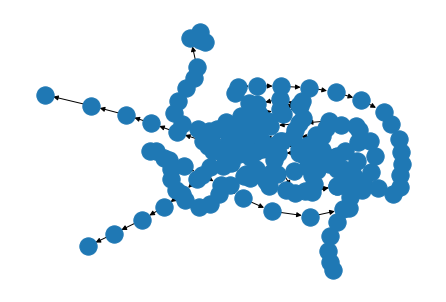

In [50]:
#print("Total Nodes:", len(g))
nx.draw(g, with_labels=False)

In [99]:
g.nodes['rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1']

{'score': 61, 'count': 72488, 'movelist': {'': 72488}}

In [ ]:
def varWeighted(scores, counts):
    if (len(counts)<2):
        return None
    else:
        weightedMean = sum([a*b for a,b in zip(scores,counts)])/sum(counts)
        scoreDiffs = [(score - weightedMean)**2 for score in scores]
        V1 = sum(counts)
        V2 = sum([count**2 for count in counts])
        var = (V1/(V1**2-V2)) * sum([a*b for a,b in zip(counts,scoreDiffs)])
        return var

In [20]:
start = timeit.default_timer()

board = chess.Board()
board.push_san('d4') #push the move to the board
board.push_san('Nf6') #push the move to the board
currFen = board.fen()
scores = []
counts = []
for neighbor in list(g.neighbors(currFen)):
    scores.append(nx.get_node_attributes(g, 'score')[neighbor])
    counts.append(nx.get_node_attributes(g, 'count')[neighbor])
    
print("var:",varWeighted(scores, counts))

stop = timeit.default_timer()
print('Time: ', stop - start) 

NetworkXError: The node rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 1 2 is not in the digraph.

In [18]:
root = ['e4', 'c5']
safe = ['e4', 'c5', 'c3']
risky = ['e4', 'c5', 'd4']

root2 = ['e4', 'e6', 'd4', 'd5']
popular2 = ['e4', 'e6', 'd4', 'd5', 'Nc3']
popular21 = ['e4', 'e6', 'd4', 'd5', 'Nd2']
safe2 = ['e4', 'e6', 'd4', 'd5', 'exd5']
risky2 = ['e4', 'e6', 'd4', 'd5', 'e5']

Ruy = ['e4', 'e5','Nf3', 'Nc6','Bb5']
Vienna = ['e4' ,'e5','d4','exd4','c3']
games = [root,safe,risky,root2,popular2, popular21,safe2,risky2, Ruy, Vienna]
for game in games:
    board = chess.Board()
    for move in game:
        board.push_san(move)
    currFen = board.fen()
    scores = []
    counts = []
    for neighbor in list(g.neighbors(currFen)):
        scores.append(nx.get_node_attributes(g, 'score')[neighbor])
        counts.append(nx.get_node_attributes(g, 'count')[neighbor])

    print('Var {}:'.format(game), varWeighted(scores,counts), ", total Games:", sum(counts), ', TIE%:', nx.get_node_attributes(g, 'tie')[currFen]/sum(counts)*100)

NetworkXError: The node rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2 is not in the digraph.

In [ ]:
root = ['e4', 'c5']
safe = ['e4', 'c5', 'c3']
risky = ['e4', 'c5', 'd4']

root2 = ['e4', 'e6', 'd4', 'd5']
popular2 = ['e4', 'e6', 'd4', 'd5', 'Nc3']
popular21 = ['e4', 'e6', 'd4', 'd5', 'Nd2']
safe2 = ['e4', 'e6', 'd4', 'd5', 'exd5']
risky2 = ['e4', 'e6', 'd4', 'd5', 'e5']

Ruy = ['e4', 'e5','Nf3', 'Nc6','Bb5']
Vienna = ['e4' ,'e5','d4','exd4','c3']
games = [root,safe,risky,root2,popular2, popular21,safe2,risky2, Ruy, Vienna]


for game in games:
    board = chess.Board()
    for move in game:
        board.push_san(move)
    currFen = board.fen()
    stockfish.set_fen_position(currFen)
    info = stockfish.get_evaluation()['value']

    print(game,"Score:", info)

In [19]:
stockfish.set_fen_position("rnbqkbnr/pp1ppppp/8/2p5/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2")
stockfish.get_evaluation()['value']

97

In [ ]:
# ###Chess Gambits
# Polish Gambit 1. e4 b5
# Wing Gambit 1. e4 c5 2. b4
# Ware Gambit 1. a4 e5 2. a5 d5 3. e3 f5 4. a6
# Birmingham Gambit 1. b4 c5
# Schuhler Gambit 1. b4 c6 2. Bb2 a5 3. b5 cxb5 4. e4
# Wolferts Gambit 1. b4 e5 2. Bb2 c5
# Englund Gambit 1. d4 e5
# Budapest Gambit 1. d4 Nf6 2. c4 e5
# Benko Gambit 1. d4 Nf6 2. c4 c5 3. d5 b5
# Staunton Gambit 1. d4 f5 2. e4
# Smith-Morra Gambit 1. e4 c5 2. d4 cxd4 3. c3
# Danish Gambit 1. e4 e5 2. d4 exd4 3. c3
# Vienna Gambit 1. e4 e5 2. Nc3 Nf6 3. f4
# King's Gambit 1. e4 e5 2. f4
# Quaade Gambit 1. e4 e5 2. f4 exf4 3. Nf3 g5 4. Nc3
# Kieseritsky Gambit 1. e4 e5 2. Nc3 Nf6 3. Bc4 Nxe4 4. Nf3
# Rice Gambit 1. e4 e5 2. f4 exf4 3. Nf3 g5 4. h4 g4 5. Ne5 Nf6 6. Bc4 d5 7. exd5 Bd6 8. 0-0
# Elephant Gambit 1. e4 e5 2. Nf3 d5
# Latvian Gambit 1. e4 e5 2. Nf3 f5
# Irish Gambit 1. e4 e5 2. Nf3 Nc6 3. Nxe5?
# Halloween Gambit 1. e4 e5 2. Nf3 Nc6 3. Nc3 Nf6 4. Nxe5?!
# Blackburne Shilling Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Nd4
# Italian Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. d4
# Rousseau Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 f5
# Evans Gambit 1. e4 e5 2. Nf3 Nc6 3. Bc4 Bc5 4. b4
# Blackmar–Diemer Gambit 1. d4 d5 2. e4 dxe4 3. Nc3
# Queen's Gambit 1. d4 d5 2. c4
# Grünfeld Gambit 1. d4 Nf6 2. c4 g6 3. Nc3 d5 4. Bf4 Bg7 5. e3 0-0

In [87]:
#THis has been deprecated becasue it has redundant grep calls
# game_file = "Lichess2013noNumbers.txt"
# start = timeit.default_timer()

# g = nx.DiGraph()
# g.add_node('')
# X = 0
# cnt = 0
# for string in stringList[:10]:
#     if(cnt%50 == 0):
#         print("strings processed:", cnt)
#     board = chess.Board()
#     moveString = '^ \+'
#     parentFen = ''
#     for move in string:
#         moveString += move + ' \+'
#         try: 
#             board.push_san(move) #push the move to the board
#             currFen = board.fen() #get the fen from the board
#              #BASH SCRIPT TO GET COUNT
#                 #pipe big grep into temp file, cat/query that
#                 #eliminate duplicate count call
#                 #grep -o '.$' | sort |unique- c
#             command = "grep -I '{}'  {} | wc -l".format(moveString, game_file)
#             process = subprocess.Popen(command, stdout=subprocess.PIPE, stderr=None, shell=True)
#             output = process.communicate()
#             count = int(re.findall('\d+',str(output))[0])
#             #BASH TO GET WIN PERCENT White
#             commandWhite = "grep -I '{}'  {} | grep -I '[0]$' | wc -l".format(moveString, game_file)
#             process = subprocess.Popen(commandWhite, stdout=subprocess.PIPE, stderr=None, shell=True)
#             output = process.communicate()
#             countWhite = int(re.findall('\d+',str(output))[0])
#             #Black
#             commandBlack = "grep -I '{}'  {} | grep -I '[1]$' | wc -l".format(moveString, game_file)
#             process = subprocess.Popen(commandBlack, stdout=subprocess.PIPE, stderr=None, shell=True)
#             output = process.communicate()
#             countBlack = int(re.findall('\d+',str(output))[0])
#             #Tie
#             commandTie = "grep -I '{}'  {} | grep -I '[2]$' | wc -l".format(moveString, game_file)
#             process = subprocess.Popen(commandTie, stdout=subprocess.PIPE, stderr=None, shell=True)
#             output = process.communicate()
#             countTie = int(re.findall('\d+',str(output))[0])
            
#             #check if fen is new, if yes, and count is high, add new node
#             if(currFen not in g.nodes and count>=X): #only add nodes if the sequence has not yet occured and they are frequent enough 
#                 #stockfish = engine.analyse(board, chess.engine.Limit(time=0.05)) #get stockfish score of fen
#                 stockfish.set_fen_position(currFen)
                
#                 g.add_node(currFen, 
#                            score = stockfish.get_evaluation()['value'], 
#                            count = count,
# #                            whiteWins = countWhite,
# #                            blackWins = countBlack,
# #                            tie = countTie,
#                            movelist = {parentFen:count}) #make a dict of parent IDs and count
#                           # movelist = [[moveString]]) #make a list of moveStrings
#                 g.add_edge(parentFen, currFen)
#                 parentFen = currFen
#             #if fen is not new, check if movestring in list of movestrings, if not, add it and add count  
#             elif(count>=X):
#                 if(parentFen not in nx.get_node_attributes(g, 'movelist')[currFen]):
#                     #nx.get_node_attributes(g, 'movelist')[currFen] = nx.get_node_attributes(g, 'movelist')[currFen].append([moveString])
#                     nx.get_node_attributes(g, 'movelist')[currFen][parentFen] = count
#                     g.nodes[currFen]['count'] = nx.get_node_attributes(g, 'count')[currFen]+count
# #                     g.nodes[currFen]['whiteWins'] = nx.get_node_attributes(g, 'whiteWins')[currFen]+countWhite
# #                     g.nodes[currFen]['blackWins'] = nx.get_node_attributes(g, 'blackWins')[currFen]+countBlack
# #                     g.nodes[currFen]['tie'] = nx.get_node_attributes(g, 'tie')[currFen]+countTie
#                     g.add_edge(parentFen, currFen)
#                 parentFen = currFen
#             else:
#                 break
#         except: #skip any errors in the notation that cannot be pushed to a board
#             #print("EXCEPT")
#             break
#     cnt+=1
# stop = timeit.default_timer()
# print('Time: ', stop - start)
# print("totalNodes:",len(g))
# print(g.nodes)

strings processed: 0
Time:  13.804609733999769
totalNodes: 9
['', 'rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq - 0 1', 'rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBNR w KQkq - 0 2', 'rnbqkbnr/pppp1ppp/8/4p3/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2', 'rnbqkbnr/ppp2ppp/8/3pp3/3PP3/8/PPP2PPP/RNBQKBNR w KQkq - 0 3', 'rnbqkbnr/ppp2ppp/8/3pp3/3PP3/2P5/PP3PPP/RNBQKBNR b KQkq - 0 3', 'rnbqkbnr/pppppppp/8/8/3P4/8/PPP1PPPP/RNBQKBNR b KQkq - 0 1', 'rnbqkbnr/pppp1ppp/8/4p3/3P4/8/PPP1PPPP/RNBQKBNR w KQkq - 0 2', 'rnbqkbnr/ppp2ppp/8/3pp3/3PP3/P7/1PP2PPP/RNBQKBNR b KQkq - 0 3']
